[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/08_conditional_manatees.ipynb)

# 8. Conditional Manatees

In [105]:
import os
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from collections import namedtuple
import statsmodels.formula.api as smf

import random
import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# to use 'sample_distributions'
import tensorflow_probability as tfpx
tfdx = tfpx.distributions
tfbx = tfpx.bijectors

plt.rcParams['figure.figsize'] = [6, 5]

In [30]:
key = tfp.util.SeedStream(8, salt="ch-08")

## 8.1 Building an interaction

### 8.1.1 Making a rugged model

##### Code 8.1


Every inference is conditional on something whether we notice it or not !

So far in the book, it was assumed that the predictor variable has an independent association with the mean of the outcome. What if want to allow the association to be conditional ?

In [32]:
d = pd.read_csv("./data/rugged.csv", sep=";")

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

Note - terrain ruggedness is divided by the maximum value observed

##### Code 8.2

In [56]:
# tfpx version
def model_81n(rugged_std, scale_a, scale_b):
    def _generator():
        a = yield tfdx.Normal(loc=1.0, scale=scale_a, name="a")
        b = yield tfdx.Normal(loc=0.0, scale=scale_b, name="b")
        sigma = yield tfdx.Exponential(rate=1.0, name="sigma")
        mu = a + b * (rugged_std - 0.215)
        yield tfdx.Normal(loc=mu, scale=sigma, name="log_gdp_std")

    return tfdx.JointDistributionCoroutineAutoBatched(_generator, validate_args=False)

##### Code 8.3

In [34]:
rugged_seq = np.linspace(-0.1, 1.1, num=30)
jd_81n_test = model_81n(rugged_std=rugged_seq, scale_a=1.0, scale_b=1.0)

In [35]:
ds_81, ss_81 = jd_81n_test.sample_distributions(50)

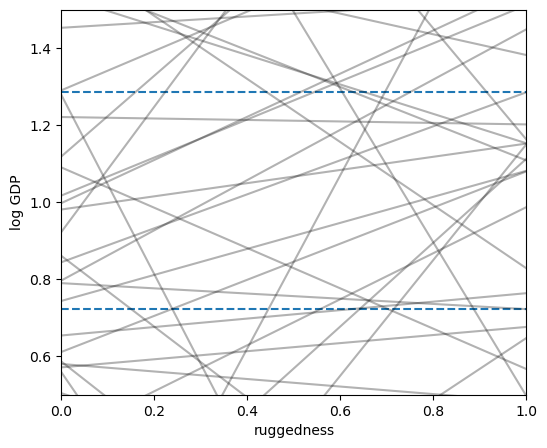

In [36]:
mu = ds_81[-1].loc

plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5), xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

##### Code 8.4

In [37]:
idx_81 = ss_81._field_name_to_index
np.sum(np.abs(ss_81[idx_81['b']]) > 0.6) / ss_81[idx_81['b']].shape[0]

0.36

##### Code 8.5

In [38]:
rugged_seq = np.linspace(-0.1, 1.1, num=30)
jd_81n_test = model_81n(rugged_std=rugged_seq, scale_a=0.1, scale_b=0.3)

In [39]:
ds_81, ss_81 = jd_81n_test.sample_distributions(50)

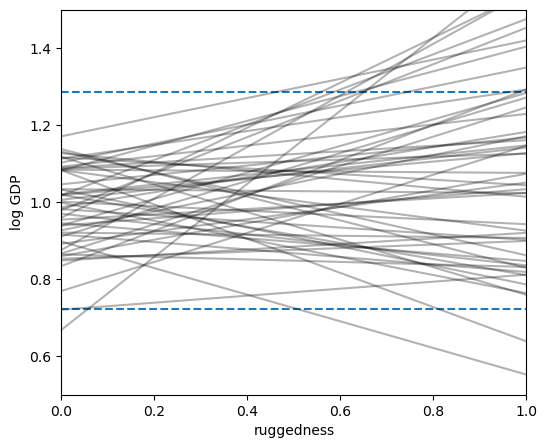

In [40]:
mu = ds_81[-1].loc

plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5), xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

##### Code 8.6

In [41]:
def model_81(rugged_std, scale_a, scale_b):
    def _generator():
        a = yield tfd.Normal(loc=1.0, scale=scale_a, name="a")
        b = yield tfd.Normal(loc=0.0, scale=scale_b, name="b")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = a + b * (rugged_std - 0.215)
        yield tfd.Normal(loc=mu, scale=sigma, name="log_gdp_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [42]:
jd_81 = model_81(dd.rugged_std.values, scale_a=0.1, scale_b=0.3)

In [43]:
jd_81_pd = jd_81.experimental_pin(log_gdp_std=dd.log_gdp_std.values)

In [44]:
def target_log_prob_81(*states):
    return jd_81_pd.unnormalized_log_prob(states)

def sample_post_81(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_81, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1500,
        trace_fn=None, seed=seed)

In [45]:
num_chains = 4
init_state_81 = jd_81_pd.sample_unpinned(num_chains, seed=key())
post_81 = sample_post_81(init_state_81, seed=key())

In [46]:
post_81_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_81._asdict().items()}
dict_81 = dict(posterior=post_81_dict)
idata_81 = az.from_dict(**dict_81)

In [47]:
az.summary(idata_81)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.000,0.011,0.980,1.019,0.000,0.000,3185.0,2563.0,1.00
b,0.005,0.056,-0.096,0.113,0.002,0.002,552.0,737.0,1.01
sigma,0.138,0.008,0.124,0.153,0.000,0.000,3437.0,2206.0,1.00


### 8.1.2 Adding an indicator variable isn't enough

##### Code 8.7

In [48]:
# make variable to index Africa (0) or not (1)
dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

##### Code 8.8

In [49]:
def model_82(rugged_std, cid):
    def _generator():
        a = yield tfd.Normal(loc=[1.0, 1.0], scale=0.1, name="a")
        b = yield tfd.Normal(loc=0.0, scale=0.3, name="b")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = jnp.take(a, cid) + b * (rugged_std - 0.215)
        yield tfd.Normal(loc=mu, scale=sigma, name="log_gdp_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [50]:
jd_82 = model_82(dd.rugged_std.values, dd.cid.values)
jd_82_pd = jd_82.experimental_pin(log_gdp_std=dd.log_gdp_std.values)

In [51]:
def target_log_prob_82(*states):
    return jd_82_pd.unnormalized_log_prob(states)

def sample_post_82(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_82, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1500,
        trace_fn=None, seed=seed)

In [52]:
num_chains = 4
init_state_82 = jd_82_pd.sample_unpinned(num_chains, seed=key())
post_82 = sample_post_82(init_state_82, seed=key())

In [53]:
post_82_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_82._asdict().items()}
dict_82 = dict(posterior=post_82_dict)
idata_82 = az.from_dict(**dict_82)

In [54]:
az.summary(idata_82)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.880,0.016,0.850,0.909,0.000,0.000,1980.0,2118.0,1.0
a[1],1.049,0.010,1.031,1.069,0.000,0.000,3553.0,3016.0,1.0
b,-0.048,0.045,-0.132,0.032,0.002,0.001,651.0,933.0,1.0
sigma,0.114,0.006,0.102,0.126,0.000,0.000,3992.0,2389.0,1.0


##### Code 8.9

In [94]:
jd_81n = model_81n(rugged_std=dd.rugged_std.values, scale_a=0.1, scale_b=0.3)
ds_81, _ = jd_81n.sample_distributions(value=post_81)

In [95]:
ds_81._field_name_to_index

{'a': 0, 'b': 1, 'sigma': 2, 'log_gdp_std': 3}

In [96]:
ll_81 = ds_81[3].log_prob(dd.log_gdp_std.values)
ll_81 = np.moveaxis(ll_81, 0, 1)

In [63]:
dict_81.update(log_likelihood={'ll': ll_81},
               dims={"ll": ["obs"]},
               coords={"obs": np.arange(len(dd.log_gdp_std.values))})
idata_81 = az.from_dict(**dict_81)

In [64]:
az.waic(idata_81, scale='deviance')

Computed from 4000 posterior samples and 170 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  -188.86    12.96
p_waic            2.58        -

In [129]:
def model_82n(rugged_std, cid):
    def _generator():
        a = yield tfdx.Normal(loc=[1.0, 1.0], scale=0.1, name="a")
        b = yield tfdx.Normal(loc=0.0, scale=0.3, name="b")
        sigma = yield tfdx.Exponential(rate=1.0, name="sigma")
        # np.take, jnp.take not working
        mu = tf.gather(a, cid) + b * (rugged_std - 0.215)
        yield tfdx.Normal(loc=mu, scale=sigma, name="log_gdp_std")

    return tfdx.JointDistributionCoroutineAutoBatched(_generator)

In [130]:
# tf functions work only with tf tensors
rugged_std_tensor = tf.convert_to_tensor(dd.rugged_std.values, dtype=tf.float32)
cid_tensor = tf.convert_to_tensor(dd.cid.values, dtype=tf.int32)

jd_82n = model_82n(rugged_std_tensor, cid_tensor)

In [132]:
ds_82, _ = jd_82n.sample_distributions(value=post_82)

In [134]:
ds_82._field_name_to_index

{'a': 0, 'b': 1, 'sigma': 2, 'log_gdp_std': 3}

In [135]:
ll_82 = ds_82[3].log_prob(dd.log_gdp_std.values)
ll_82 = np.moveaxis(ll_82, 0, 1)

In [154]:
dict_82.update(log_likelihood={'ll': ll_82},
               dims={"ll": ["obs"]},
               coords={"obs": np.arange(len(dd.log_gdp_std.values))})
idata_82 = az.from_dict(**dict_82)

In [155]:
az.waic(idata_82, scale='deviance')

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 170 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  -252.57    14.80
p_waic            3.99        -

There has been a warning during the calculation. Please check the results.

In [139]:
az.compare({"m8.1": idata_81, "m8.2": idata_82}, ic="waic", scale="deviance")

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.2,0,-252.56914,3.986704,0.00000,0.970202,14.802634,0.000000,True,deviance
m8.1,1,-188.85666,2.578659,63.71248,0.029798,12.956697,14.620128,False,deviance


##### Code 8.11

In [165]:
az.summary(idata_82.posterior['a'][..., 0] - idata_82.posterior['a'][..., 1], hdi_prob=0.88)

,mean,sd,hdi_6%,hdi_94%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.169,0.019,-0.199,-0.14,0.0,0.0,2548.0,1955.0,1.0


##### Code 8.13

In [166]:
def model_83(rugged_std, cid):
    def _generator():
        a = yield tfd.Normal(loc=[1.0, 1.0], scale=0.1, name="a")
        b = yield tfd.Normal(loc=[0.0, 0.0], scale=0.3, name="b")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = jnp.take(a, cid) + jnp.take(b, cid) * (rugged_std - 0.215)
        yield tfd.Normal(loc=mu, scale=sigma, name="log_gdp_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [167]:
jd_83 = model_83(dd.rugged_std.values, dd.cid.values)
jd_83_pd = jd_83.experimental_pin(log_gdp_std=dd.log_gdp_std.values)

In [168]:
def target_log_prob_83(*states):
    return jd_83_pd.unnormalized_log_prob(states)

def sample_post_83(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_83, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1500,
        trace_fn=None, seed=seed)

In [184]:
num_chains = 4
init_state_83 = jd_83_pd.sample_unpinned(num_chains, seed=key())
post_83 = sample_post_83(init_state_83, seed=key())

In [185]:
post_83_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_83._asdict().items()}
dict_83 = dict(posterior=post_83_dict)
idata_83 = az.from_dict(**dict_83)

In [186]:
az.summary(idata_83)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.887,0.016,0.858,0.918,0.000,0.000,3381.0,2625.0,1.00
a[1],1.050,0.010,1.032,1.071,0.000,0.000,3729.0,2410.0,1.00
b[0],0.129,0.075,-0.008,0.273,0.002,0.002,1094.0,1522.0,1.01
b[1],-0.141,0.056,-0.241,-0.033,0.002,0.001,1228.0,891.0,1.00
sigma,0.112,0.006,0.100,0.123,0.000,0.000,4184.0,2817.0,1.00


##### Code 8.15

In [172]:
def model_83n(rugged_std, cid):
    def _generator():
        a = yield tfdx.Normal(loc=[1.0, 1.0], scale=0.1, name="a")
        b = yield tfdx.Normal(loc=[0.0, 0.0], scale=0.3, name="b")
        sigma = yield tfdx.Exponential(rate=1.0, name="sigma")
        mu = tf.gather(a, cid) + tf.gather(b, cid) * (rugged_std - 0.215)
        yield tfdx.Normal(loc=mu, scale=sigma, name="log_gdp_std")

    return tfdx.JointDistributionCoroutineAutoBatched(_generator)

In [173]:
rugged_std_tensor = tf.convert_to_tensor(dd.rugged_std.values, dtype=tf.float32)
cid_tensor = tf.convert_to_tensor(dd.cid.values, dtype=tf.int32)

jd_83n = model_83n(rugged_std_tensor, cid_tensor)

In [187]:
ds_83, _ = jd_83n.sample_distributions(value=post_83)

In [176]:
ds_83._field_name_to_index

{'a': 0, 'b': 1, 'sigma': 2, 'log_gdp_std': 3}

In [188]:
ll_83 = ds_82[3].log_prob(dd.log_gdp_std.values)
ll_83 = np.moveaxis(ll_83, 0, 1)

In [189]:
dict_83.update(log_likelihood={'ll': ll_83},
               dims={"ll": ["obs"]},
               coords={"obs": np.arange(len(dd.log_gdp_std.values))})
idata_83 = az.from_dict(**dict_83)

In [190]:
az.compare({"m8.1": idata_81, "m8.2": idata_82, "m8.3": idata_83}, ic='loo', scale="deviance")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m8.2,0,-252.532418,4.005064,0.000000,0.485076,14.810944,0.000000,False,deviance
m8.3,1,-252.532291,4.005128,0.000127,0.484847,14.810975,0.000078,False,deviance
m8.1,2,-188.846403,2.583787,63.686015,0.030076,12.957343,14.626487,False,deviance


In [193]:
az.loo(idata_83)

Computed from 4000 posterior samples and 170 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   126.27     7.41
p_loo        4.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      170  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### 8.1.4 Plotting the interaction

##### Code 8.17

In [199]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

# Africa, cid=0
jd_83_cid2 = model_83n(rugged_std=rugged_seq, cid=np.repeat(0, 30))
ds_cid2, _ = jd_83_cid2.sample_distributions(value=post_83)
Africa_mu = np.mean(ds_cid2[-1].loc, axis=(0, 1))
Africa_ci = np.percentile(ds_cid2[-1].loc, q=(1.5, 98.5), axis=(0, 1))

# NotAfrica, cid=1
jd_83_cid1 = model_83n(rugged_std=rugged_seq, cid=np.repeat(1, 30))
ds_cid1, _ = jd_83_cid1.sample_distributions(value=post_83)
notAfrica_mu = np.mean(ds_cid1[-1].loc, axis=(0, 1))
notAfrica_ci = np.percentile(ds_cid1[-1].loc, q=(1.5, 98.5), axis=(0, 1))

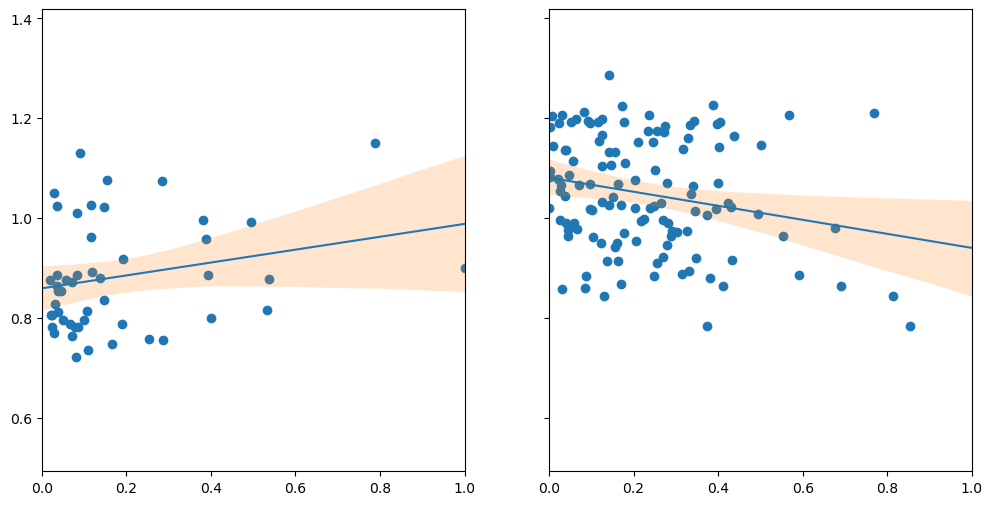

In [210]:
Africa_idx = dd['cid'] == 0
notAfrica_idx = dd['cid'] == 1

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

ax[0].scatter(dd['rugged_std'][Africa_idx], dd['log_gdp_std'][Africa_idx])
ax[0].plot(rugged_seq, Africa_mu)
ax[0].fill_between(rugged_seq, Africa_ci[0], Africa_ci[1], alpha=0.2)
ax[0].set_xlim(0.0, 1.0)

ax[1].scatter(dd['rugged_std'][notAfrica_idx], dd['log_gdp_std'][notAfrica_idx])
ax[1].plot(rugged_seq, notAfrica_mu)
ax[1].fill_between(rugged_seq, notAfrica_ci[0], notAfrica_ci[1], alpha=0.2);

## 8.3 Continuous interactions

### 8.3.1 A winter flower

##### Code 8.19

In [121]:
d = pd.read_csv("./data/tulips.csv", sep=";")
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 996.0+ bytes


##### Code 8.20

In [122]:
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()
d.head()

,bed,water,shade,blooms,blooms_std,water_cent,shade_cent
0,a,1,1,0.00,0.000000,-1.0,-1.0
1,a,1,2,0.00,0.000000,-1.0,0.0
2,a,1,3,111.04,0.307029,-1.0,1.0
3,a,2,1,183.47,0.507300,0.0,-1.0
4,a,2,2,59.16,0.163579,0.0,0.0


##### Code 8.21

In [11]:
type(1e4)

float

In [13]:
a = tfd.Normal(loc=0.5, scale=1.0).sample(10000, seed=key())
np.sum((a < 0) | (a > 1)) / a.shape[0]

Array(0.6163, dtype=float32)

##### Code 8.22

In [15]:
a = tfd.Normal(loc=0.5, scale=0.25).sample(10000, seed=key())
np.sum((a < 0) | (a > 1)) / a.shape[0]

Array(0.0455, dtype=float32)

##### Code 8.23

In [17]:
def model_84(water_cent, shade_cent):
    def _generator():
        a = yield tfd.Normal(loc=0.5, scale=0.25, name="a")
        bw = yield tfd.Normal(loc=0.0, scale=0.25, name="bw")
        bs = yield tfd.Normal(loc=0.0, scale=0.25, name="bs")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = a + bw * water_cent + bs * shade_cent
        yield tfd.Normal(loc=mu, scale=sigma, name="blooms_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [18]:
jd_84 = model_84(d.water_cent.values, d.shade_cent.values)
jd_84_pd = jd_84.experimental_pin(blooms_std=d.blooms_std.values)

In [19]:
def target_log_prob_84(*states):
    return jd_84_pd.unnormalized_log_prob(states)

def sample_post_84(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_84, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1500,
        trace_fn=None, seed=seed)

In [20]:
num_chains = 4
init_state_84 = jd_84_pd.sample_unpinned(num_chains, seed=key())
post_84 = sample_post_84(init_state_84, seed=key())

In [21]:
post_84_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_84._asdict().items()}
dict_84 = dict(posterior=post_84_dict)
idata_84 = az.from_dict(**dict_84)

In [22]:
az.summary(idata_84)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.359,0.034,0.296,0.426,0.001,0.000,3233.0,2845.0,1.0
bs,-0.113,0.041,-0.187,-0.034,0.001,0.001,2409.0,2583.0,1.0
bw,0.204,0.042,0.125,0.282,0.001,0.001,2248.0,2085.0,1.0
sigma,0.176,0.027,0.129,0.229,0.001,0.000,2895.0,2515.0,1.0


##### Code 8.24

In [23]:
def model_85(water_cent, shade_cent):
    def _generator():
        a = yield tfd.Normal(loc=0.5, scale=0.25, name="a")
        bw = yield tfd.Normal(loc=0.0, scale=0.25, name="bw")
        bs = yield tfd.Normal(loc=0.0, scale=0.25, name="bs")
        bws = yield tfd.Normal(loc=0.0, scale=0.25, name="bws")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = a + bw * water_cent + bs * shade_cent + bws * water_cent*shade_cent
        yield tfd.Normal(loc=mu, scale=sigma, name="blooms_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [24]:
jd_85 = model_85(d.water_cent.values, d.shade_cent.values)
jd_85_pd = jd_85.experimental_pin(blooms_std=d.blooms_std.values)

In [25]:
def target_log_prob_85(*states):
    return jd_85_pd.unnormalized_log_prob(states)

def sample_post_85(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_85, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1500,
        trace_fn=None, seed=seed)

In [26]:
num_chains = 4
init_state_85 = jd_85_pd.sample_unpinned(num_chains, seed=key())
post_85 = sample_post_85(init_state_85, seed=key())

In [27]:
post_85_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_85._asdict().items()}
dict_85 = dict(posterior=post_85_dict)
idata_85 = az.from_dict(**dict_85)

In [28]:
az.summary(idata_85)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.359,0.027,0.308,0.411,0.000,0.000,3530.0,2207.0,1.0
bs,-0.113,0.033,-0.172,-0.049,0.001,0.000,3103.0,2597.0,1.0
bw,0.206,0.034,0.145,0.272,0.001,0.000,2970.0,2133.0,1.0
bws,-0.142,0.042,-0.220,-0.064,0.001,0.001,2376.0,2315.0,1.0
sigma,0.142,0.022,0.103,0.182,0.000,0.000,3508.0,2665.0,1.0


### 8.3.3 Plotting posterior predictions

##### Code 8.25

In [106]:
# tfpx version
def model_84x(water_cent, shade_cent):
    def _generator():
        a = yield tfdx.Normal(loc=0.5, scale=0.25, name="a")
        bw = yield tfdx.Normal(loc=0.0, scale=0.25, name="bw")
        bs = yield tfdx.Normal(loc=0.0, scale=0.25, name="bs")
        sigma = yield tfdx.Exponential(rate=1.0, name="sigma")
        mu = a + bw * water_cent + bs * shade_cent
        yield tfdx.Normal(loc=mu, scale=sigma, name="blooms_std")

    return tfdx.JointDistributionCoroutineAutoBatched(_generator)

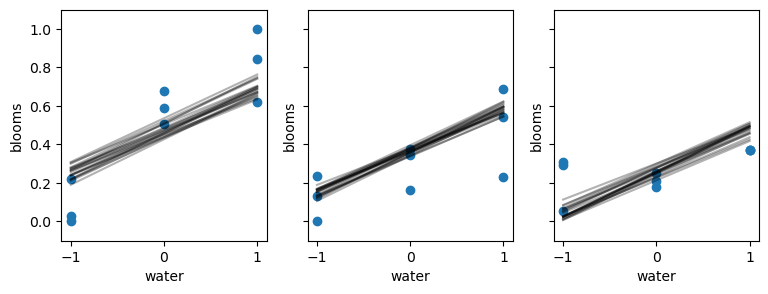

In [135]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
for ax, s in zip(axes, np.array([-1., 0., 1.])):
    idx = d.shade_cent.values == s
    ax.scatter(d.water_cent.values[idx], d.blooms_std.values[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent = s
    water_cent = np.array([-1., 0., 1.])

    jd_84x = model_84x(water_cent, shade_cent)
    ds, _ = jd_84x.sample_distributions(value=post_84)
    # ds[-1].loc: (draw, chain, obs) --> (1000, 4, 3)
    # mean through chains
    mu = ds[-1].loc.numpy().mean(axis=1) 

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

In [137]:
def model_85x(water_cent, shade_cent):
    def _generator():
        a = yield tfdx.Normal(loc=0.5, scale=0.25, name="a")
        bw = yield tfdx.Normal(loc=0.0, scale=0.25, name="bw")
        bs = yield tfdx.Normal(loc=0.0, scale=0.25, name="bs")
        bws = yield tfdx.Normal(loc=0.0, scale=0.25, name="bws")
        sigma = yield tfdx.Exponential(rate=1.0, name="sigma")
        mu = a + bw * water_cent + bs * shade_cent + bws * water_cent*shade_cent
        yield tfdx.Normal(loc=mu, scale=sigma, name="blooms_std")

    return tfdx.JointDistributionCoroutineAutoBatched(_generator)

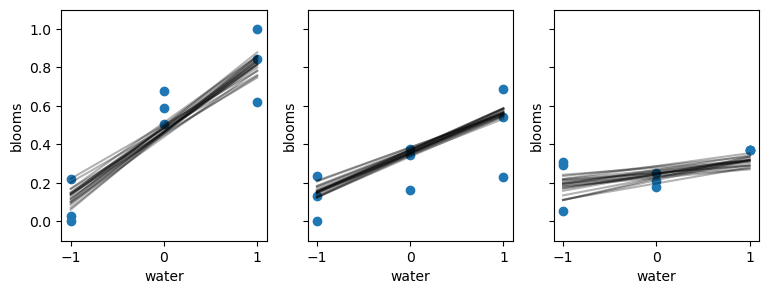

In [138]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
for ax, s in zip(axes, np.array([-1., 0., 1.])):
    idx = d.shade_cent.values == s
    ax.scatter(d.water_cent.values[idx], d.blooms_std.values[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent = s
    water_cent = np.array([-1., 0., 1.])

    jd_85x = model_85x(water_cent, shade_cent)
    ds, _ = jd_85x.sample_distributions(value=post_85)
    # ds[-1].loc: (draw, chain, obs) --> (1000, 4, 3)
    # mean through chains --> (1000, 3)
    mu = ds[-1].loc.numpy().mean(axis=1) 

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)